------
**You cannot save any changes you make to this file, so please make sure to save it on your Google Colab drive or download it as a .ipynb file.**

------



Practical 1: Sentiment Detection in Movie Reviews
========================================



This practical concerns detecting sentiment in movie reviews. This is a typical NLP classification task.
In [this file](https://gist.githubusercontent.com/bastings/d47423301cca214e3930061a5a75e177/raw/5113687382919e22b1f09ce71a8fecd1687a5760/reviews.json) (80MB) you will find 1000 positive and 1000 negative **movie reviews**.
Each review is a **document** and consists of one or more sentences.

To prepare yourself for this practical, you should
have a look at a few of these texts to understand the difficulties of
the task: how might one go about classifying the texts? You will write
code that decides whether a movie review conveys positive or
negative sentiment.

Please make sure you have read the following paper:

>   Bo Pang, Lillian Lee, and Shivakumar Vaithyanathan
(2002).
[Thumbs up? Sentiment Classification using Machine Learning
Techniques](https://dl.acm.org/citation.cfm?id=1118704). EMNLP.

Bo Pang et al. introduced the movie review sentiment
classification task, and the above paper was one of the first papers on
the topic. The first version of your sentiment classifier will do
something similar to Pang et al.'s system. If you have questions about it,
you should resolve you doubts as soon as possible with your TA.


**Advice**

Please read through the entire practical and familiarise
yourself with all requirements before you start coding or otherwise
solving the tasks. Writing clean and concise code can make the difference
between solving the assignment in a matter of hours, and taking days to
run all experiments.


**Implementation**

While we inserted code cells to indicate where you should implement your own code, please feel free to add/remove code blocks where you see fit (but make sure that the general structure of the assignment is preserved). Also, please keep in mind that it is always good practice to structure your code properly, e.g., by implementing separate classes and functions that can be reused. **Make sure you run all your code before submitting the notebook, and do not leave unnecessary print statements / cells in your notebook that are not intended for the grader.**

## Environment

All code should be written in **Python 3**.
This is the default in Google Colab.

In [1]:
!python --version

Python 3.12.7


If you want to run code on your own computer, then download this notebook through `File -> Download .ipynb`.
The easiest way to
install Python is through downloading
[Anaconda](https://www.anaconda.com/download).
After installation, you can start the notebook by typing `jupyter notebook filename.ipynb`.
You can also use an IDE
such as [PyCharm](https://www.jetbrains.com/pycharm/download/) to make
coding and debugging easier. It is good practice to create a [virtual
environment](https://docs.python.org/3/tutorial/venv.html) for this
project, so that any Python packages don’t interfere with other
projects.


**Learning Python 3**

If you are new to Python 3, you may want to check out a few of these resources:
- https://learnxinyminutes.com/docs/python3/
- https://www.learnpython.org/
- https://docs.python.org/3/tutorial/

In [26]:
import math
import os
import sys
from subprocess import call
from nltk import FreqDist
from nltk.util import ngrams
from nltk.stem.porter import PorterStemmer
import sklearn as sk
#from google.colab import drive
import pickle
import json
from collections import Counter
import requests
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

## Loading the data

**Download the sentiment lexicon and the movie reviews dataset.**

In [2]:
# download sentiment lexicon
!wget https://gist.githubusercontent.com/bastings/d6f99dcb6c82231b94b013031356ba05/raw/f80a0281eba8621b122012c89c8b5e2200b39fd6/sent_lexicon
# download review data
!wget https://gist.githubusercontent.com/bastings/d47423301cca214e3930061a5a75e177/raw/5113687382919e22b1f09ce71a8fecd1687a5760/reviews.json

--2024-11-07 10:54:39--  https://gist.githubusercontent.com/bastings/d6f99dcb6c82231b94b013031356ba05/raw/f80a0281eba8621b122012c89c8b5e2200b39fd6/sent_lexicon
Resolviendo gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Conectando con gist.githubusercontent.com (gist.githubusercontent.com)[185.199.108.133]:443... conectado.
Petición HTTP enviada, esperando respuesta... 200 OK
Longitud: 662577 (647K) [text/plain]
Grabando a: «sent_lexicon.1»

sent_lexicon.1      100%[===================>] 647.05K  --.-KB/s    en 0.08s   

2024-11-07 10:54:40 (7.49 MB/s) - «sent_lexicon.1» guardado [662577/662577]

--2024-11-07 10:54:40--  https://gist.githubusercontent.com/bastings/d47423301cca214e3930061a5a75e177/raw/5113687382919e22b1f09ce71a8fecd1687a5760/reviews.json
Resolviendo gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Conectando con gist.githubusercontent.com (g

**Load the movie reviews.**

Each word in a review comes with its part-of-speech tag. For documentation on POS-tags, see https://catalog.ldc.upenn.edu/docs/LDC99T42/tagguid1.pdf.


In [2]:
# file structure:
# [
#  {"cv": integer, "sentiment": str, "content": list}
#  {"cv": integer, "sentiment": str, "content": list}
#   ..
# ]
# where `content` is a list of sentences,
# with a sentence being a list of (token, pos_tag) pairs.


with open("reviews.json", mode="r", encoding="utf-8") as f:
  reviews = json.load(f)

print("Total number of reviews:", len(reviews), '\n')

def print_sentence_with_pos(s):
  print(" ".join("%s/%s" % (token, pos_tag) for token, pos_tag in s))

for i, r in enumerate(reviews):
  print(r["cv"], r["sentiment"], len(r["content"]))  # cv, sentiment, num sents
  print_sentence_with_pos(r["content"][0])
  if i == 4:
    break

c = Counter()
for review in reviews:
  for sentence in review["content"]:
    for token, pos_tag in sentence:
      c[token.lower()] += 1

print("\nNumber of word types:", len(c))
print("Number of word tokens:", sum(c.values()))

print("\nMost common tokens:")
for token, count in c.most_common(20):
  print("%10s : %8d" % (token, count))


Total number of reviews: 2000 

0 NEG 29
Two/CD teen/JJ couples/NNS go/VBP to/TO a/DT church/NN party/NN ,/, drink/NN and/CC then/RB drive/NN ./.
1 NEG 11
Damn/JJ that/IN Y2K/CD bug/NN ./.
2 NEG 24
It/PRP is/VBZ movies/NNS like/IN these/DT that/WDT make/VBP a/DT jaded/JJ movie/NN viewer/NN thankful/JJ for/IN the/DT invention/NN of/IN the/DT Timex/NNP IndiGlo/NNP watch/NN ./.
3 NEG 19
QUEST/NN FOR/IN CAMELOT/NNP ``/`` Quest/NNP for/IN Camelot/NNP ''/'' is/VBZ Warner/NNP Bros./NNP '/POS first/JJ feature-length/JJ ,/, fully-animated/JJ attempt/NN to/TO steal/VB clout/NN from/IN Disney/NNP 's/POS cartoon/NN empire/NN ,/, but/CC the/DT mouse/NN has/VBZ no/DT reason/NN to/TO be/VB worried/VBN ./.
4 NEG 38
Synopsis/NNPS :/: A/DT mentally/RB unstable/JJ man/NN undergoing/VBG psychotherapy/NN saves/VBZ a/DT boy/NN from/IN a/DT potentially/RB fatal/JJ accident/NN and/CC then/RB falls/VBZ in/IN love/NN with/IN the/DT boy/NN 's/POS mother/NN ,/, a/DT fledgling/NN restauranteur/NN ./.

Number of wo

#(1) Lexicon-based approach (3.5pts)



A traditional approach to classify documents according to their sentiment is the lexicon-based approach. To implement this approach, you need a **sentiment lexicon**, i.e., a list of words annotated with a sentiment label (e.g., positive and negative, or a score from 0 to 5).

In this practical, you will use the sentiment
lexicon released by Wilson et al. (2005).

> Theresa Wilson, Janyce Wiebe, and Paul Hoffmann
(2005). [Recognizing Contextual Polarity in Phrase-Level Sentiment
Analysis](http://www.aclweb.org/anthology/H/H05/H05-1044.pdf). HLT-EMNLP.

Pay attention to all the information available in the sentiment lexicon. The field *word1* contains the lemma, *priorpolarity* contains the sentiment label (positive, negative, both, or neutral), *type* gives you the magnitude of the word's sentiment (strong or weak), and *pos1* gives you the part-of-speech tag of the lemma. Some lemmas can have multiple part-of-speech tags and thus multiple entries in the lexicon. The path of the lexicon file is `"sent_lexicon"`.


In [3]:
with open("sent_lexicon", mode="r", encoding="utf-8") as f:
  line_cnt = 0
  for line in f:
    print(line.strip())
    line_cnt += 1
    if line_cnt > 4:
      break

type=weaksubj len=1 word1=abandoned pos1=adj stemmed1=n priorpolarity=negative
type=weaksubj len=1 word1=abandonment pos1=noun stemmed1=n priorpolarity=negative
type=weaksubj len=1 word1=abandon pos1=verb stemmed1=y priorpolarity=negative
type=strongsubj len=1 word1=abase pos1=verb stemmed1=y priorpolarity=negative
type=strongsubj len=1 word1=abasement pos1=anypos stemmed1=y priorpolarity=negative


Lexica such as this can be used to solve
the classification task without using Machine Learning. For example, one might look up every word $w_1 ... w_n$ in a document, and compute a **binary score**
$S_{binary}$ by counting how many words have a positive or a
negative label in the sentiment lexicon $SLex$.

$$S_{binary}(w_1 w_2 ... w_n) = \sum_{i = 1}^{n}\text{sign}(SLex\big[w_i\big])$$

where $\text{sign}(SLex\big[w_i\big])$ refers to the polarity of $w_i$.

**Threshold.** On average, there are more positive than negative words per review (~7.13 more positive than negative per review) to take this bias into account you should use a threshold of **8** (roughly the bias itself) to make it harder to classify as positive.

$$
\text{classify}(S_{binary}(w_1 w_2 ... w_n)) = \bigg\{\begin{array}{ll}
        \text{positive} & \text{if } S_{binary}(w_1w_2...w_n) > threshold\\
        \text{negative} & \text{otherwise}
        \end{array}
$$


#### (Q1.1) Implement this approach and report its classification accuracy. (1 pt)

In [4]:
# YOUR CODE HERE
def get_binary_lexicon_pred(review, lexicon: dict, threshold: float = 8) -> str:
    score = 0
    review_tokens = []
    for sentence in review:
        review_tokens += [token for token, _ in sentence]
    for token in review_tokens:
        if token in lexicon:
            if lexicon[token]["polarity"] == "positive":
                score += 1
            elif lexicon[token]["polarity"] == "negative":
                score -= 1
    if score > threshold:
        return "POS", score
    else:
        return "NEG", score
    
lexicon_dict = {}
with open("sent_lexicon", mode="r", encoding="utf-8") as f:
    for line in f:
        lexicon_entry = line.strip().split()
        word = lexicon_entry[2].split("=")[1]
        polarity = lexicon_entry[5].split("=")[1]
        magnitude = lexicon_entry[0].split("=")[1]
        lexicon_dict[word] = {
            "polarity": polarity,
            "magnitude": magnitude,
        }

In [5]:
y_binary = []
for r in reviews:
    review = r["content"]
    y_binary.append(get_binary_lexicon_pred(review, lexicon_dict)[0])

In [6]:
# token_results should be a list of binary indicators; for example [1, 0, 1, ...]
# where 1 indicates a correct classification and 0 an incorrect classification.
token_results = [1 if y == y_binary[i] else 0 for i, y in enumerate([r["sentiment"] for r in reviews])]
token_accuracy = sum(token_results) / len(token_results)
print(f"Accuracy: {token_accuracy}")

Accuracy: 0.6795


As the sentiment lexicon also has information about the **magnitude** of
sentiment (e.g., *“excellent"* has the same sentiment _polarity_ as *“good"* but it has a higher magnitude), we can take a more fine-grained approach by adding up all
sentiment scores, and deciding the polarity of the movie review using
the sign of the weighted score $S_{weighted}$.

$$S_{weighted}(w_1w_2...w_n) = \sum_{i = 1}^{n}SLex\big[w_i\big]$$


Make sure you define an appropriate threshold for this approach.

#### (Q1.2) Now incorporate magnitude information and report the classification accuracy. Don't forget to use the threshold. (1pt)

In [7]:
# YOUR CODE HERE
def get_weighted_lexicon_pred(
    review: str, lexicon: dict, threshold: float = 0
) -> tuple[str, int]:
    score = 0
    review_tokens = []
    for sentence in review:
        review_tokens += [token for token, _ in sentence]
    for token in review_tokens:
        if token in lexicon:
            polarity = lexicon[token]["polarity"]

            # Transform polarity and magnitude to numerical values
            if polarity == "positive":
                polarity_value = 1
            elif polarity == "negative":
                polarity_value = -1
            else:
                polarity_value = 0

            magnitude = lexicon[token]["magnitude"]
            if magnitude == "weaksubj":
                magnitude_value = 1
            elif magnitude == "strongsubj":
                magnitude_value = 2

            score += polarity_value * magnitude_value

    if score > threshold:
        return "POS", score
    else:
        return "NEG", score


y_magnitude = []
scores = []
for r in reviews:
    review = r["content"]
    pred, score = get_weighted_lexicon_pred(review, lexicon_dict)
    y_magnitude.append(pred)
    scores.append(score)

scores = np.array(scores)

token_results_weighted = [
    1 if y == y_magnitude[i] else 0
    for i, y in enumerate([r["sentiment"] for r in reviews])
]
token_accuracy_weighted = sum(token_results_weighted) / len(token_results_weighted)
print(f"Accuracy: {token_accuracy_weighted}")
print(f"Mean score: {scores.mean()}")

Accuracy: 0.648
Mean score: 10.848


In [8]:
bias_threshold = scores.mean()
y_magnitude = []
scores = []
for r in reviews:
    review = r["content"]
    pred, score = get_weighted_lexicon_pred(review, lexicon_dict, threshold=bias_threshold)
    y_magnitude.append(pred)
    scores.append(score)

scores = np.array(scores)

token_results_weighted = [
    1 if y == y_magnitude[i] else 0
    for i, y in enumerate([r["sentiment"] for r in reviews])
]
token_accuracy_weighted = sum(token_results_weighted) / len(token_results_weighted)
print(f"Accuracy: {token_accuracy_weighted}")
print(f"Mean score: {scores.mean()}")

Accuracy: 0.69
Mean score: 10.848


In [9]:
magnitude_results = [
    1 if y == y_magnitude[i] else 0
    for i, y in enumerate([r["sentiment"] for r in reviews])
]
magnitude_accuracy = sum(token_results_weighted) / len(token_results_weighted)
print(f"Accuracy: {magnitude_accuracy}")

Accuracy: 0.69


#### (Q.1.3) Make a barplot of the two results (0.5pt)

Text(0.5, 1.0, 'Accuracy of Sentiment Analysis')

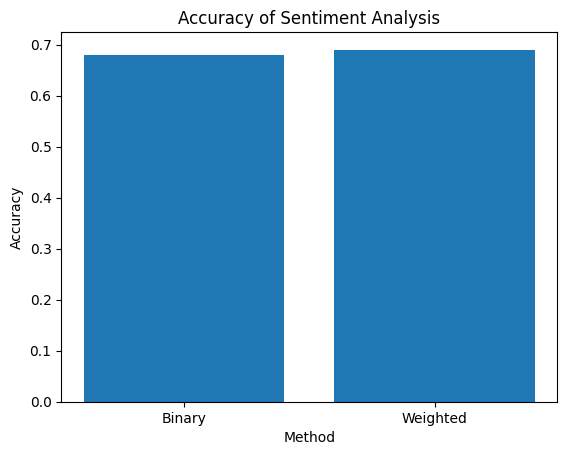

In [10]:
# YOUR CODE HERE
fig, ax = plt.subplots()

ax.bar(["Binary", "Weighted"], [token_accuracy, magnitude_accuracy])
ax.set_xlabel("Method")
ax.set_ylabel("Accuracy")
ax.set_title("Accuracy of Sentiment Analysis")

#### (Q1.4) A better threshold (1pt)
Above we have defined a threshold to account for an inherent bias in the dataset: there are more positive than negative words per review.
However, that threshold does not take into account *document length*. Explain why this is a problem and implement an alternative way to compute the threshold.

*Write your answer here.*

The problem with not accounting with sequence length is that we may have long sequence with a majority of positive or negatives words. These long sequences are outliers that impact the bias threshold we are using to classify the sentiment of the review. To solve the problem, we can normalize the score by the length of the sequence. This way, we can have a better threshold that is not biased by the length of the sequence.

In [11]:
def get_normed_lexicon_pred(review, lexicon, threshold = 2) -> tuple[str, float]:
    score = 0
    review_tokens = []
    for sentence in review:
        review_tokens += [token for token, _ in sentence]
    for token in review_tokens:
        if token in lexicon:
            polarity = lexicon[token]["polarity"]

            # Transform polarity and magnitude to numerical values
            if polarity == "positive":
                polarity_value = 1
            elif polarity == "negative":
                polarity_value = -1
            else:
                polarity_value = 0

            magnitude = lexicon[token]["magnitude"]
            if magnitude == "weaksubj":
                magnitude_value = 1
            elif magnitude == "strongsubj":
                magnitude_value = 2

            score += polarity_value * magnitude_value
    score /= len(review_tokens)
    if score > threshold:
        return "POS", score
    else:
        return "NEG", score

In [12]:
# YOUR CODE HERE
def get_length_threshold(reviews, lexicon) -> float:
    scores = []
    for r in reviews:
        review = r["content"]
        _, score = get_normed_lexicon_pred(review, lexicon)
        scores.append(score)

    scores = np.array(scores)
    threshold = scores.mean()
    return threshold

length_threshold = get_length_threshold(reviews, lexicon_dict)
print(f"Length Threshold: {length_threshold}")

y_normalized = []
for r in reviews:
    review = r["content"]
    pred, _ = get_normed_lexicon_pred(review, lexicon_dict, threshold=length_threshold)
    y_normalized.append(pred)

token_results_normalized = [
    1 if y == y_normalized[i] else 0
    for i, y in enumerate([r["sentiment"] for r in reviews])
]
token_accuracy_normalized = sum(token_results_normalized) / len(token_results_normalized)
print(f"Accuracy: {token_accuracy_normalized}")

Length Threshold: 0.013827557181057736
Accuracy: 0.6865


# (2) Naive Bayes (9.5pts)


Your second task is to program a simple Machine Learning approach that operates
on a simple Bag-of-Words (BoW) representation of the text data, as
described by Pang et al. (2002). In this approach, the only features we
will consider are the words in the text themselves, without bringing in
external sources of information. The BoW model is a popular way of
representing texts as vectors, making it
easy to apply classical Machine Learning algorithms on NLP tasks.
However, the BoW representation is also very crude, since it discards
all information related to word order and grammatical structure in the
original text—as the name suggests.

## Writing your own classifier (4pts)

Write your own code to implement the Naive Bayes (NB) classifier. As
a reminder, the Naive Bayes classifier works according to the following
equation:
$$\hat{c} = \operatorname*{arg\,max}_{c \in C} P(c|\bar{f}) = \operatorname*{arg\,max}_{c \in C} P(c)\prod^n_{i=1} P(f_i|c)$$
where $C = \{ \text{POS}, \text{NEG} \}$ is the set of possible classes,
$\hat{c} \in C$ is the most probable class, and $\bar{f}$ is the feature
vector. Remember that we use the log of these probabilities when making
a prediction:
$$\hat{c} = \operatorname*{arg\,max}_{c \in C} \Big\{\log P(c) + \sum^n_{i=1} \log P(f_i|c)\Big\}$$

You can find more details about Naive Bayes in [Jurafsky &
Martin](https://web.stanford.edu/~jurafsky/slp3/). You can also look at
this helpful
[pseudo-code](https://nlp.stanford.edu/IR-book/html/htmledition/naive-bayes-text-classification-1.html).

*Note: this section and the next aim to put you in a position to replicate
    Pang et al.'s Naive Bayes results. However, your numerical results
    will differ from theirs, as they used different data.*

**You must write the Naive Bayes training and prediction code from
scratch.** You will not be given credit for using off-the-shelf Machine
Learning libraries.

The data contains the text of the reviews, where each document consists
of the sentences in the review, the sentiment of the review and an index
(cv) that you will later use for cross-validation. The
text has already been tokenised and POS-tagged for you. Your algorithm
should read in the text, **lowercase it**, store the words and their
frequencies in an appropriate data structure that allows for easy
computation of the probabilities used in the Naive Bayes algorithm, and
then make predictions for new instances.


#### (Q2.1) Unseen words (1pt)
The presence of words in the test dataset that
have not been seen during training can cause probabilities in the Naive Bayes classifier to equal $0$.
These can be words which are unseen in both positive and negative training reviews (case 1), but also words which are seen in reviews _of only one sentiment class_ in the training dataset (case 2). In both cases, **you should skip these words for both classes at test time**.  What would be the problem instead with skipping words only for one class in case 2?

Skipping words for only one class in case 2 can create an imbalance in the data that would lead to biased predictions. This would happen because:

1. Naive Bayes sums the log probability of each word in each class. If a word is ignored in only one class, it would result in an inaccurate comparison between both classes.

2. Ignoring a word in only one class would then make the classifier biased towards that class. This happens because the log probability would be unfairly lower for the class in which the word is not being ignored, which could increase the chance to misclassify.

#### (Q2.2) Train your classifier on (positive and negative) reviews with cv-value 000-899, and test it on the remaining (positive and negative) reviews cv900–cv999.  Report results using classification accuracy as your evaluation metric. Your  features are the word vocabulary. The value of a feature is the count of that feature (word) in the document. (2pts)


In [13]:
train_reviews = [review for review in reviews if int(review["cv"]) < 900]
test_reviews = [review for review in reviews if int(review["cv"]) >= 900]

def create_vocab_and_counts(reviews):
    """ Function to create the BoW vocabulary and count dictionaries for each word / class """

    vocab = set()
    word_counts = {"positive": {}, "negative": {}}
    class_counts = {"positive": 0, "negative": 0}

    for review in reviews:

        label = "positive" if review["sentiment"] == "POS" else "negative"
        class_counts[label] += 1

        for sentence in review["content"]:
            for word, _ in sentence:
                word = word.lower()
                
                if word not in word_counts[label]:
                    word_counts[label][word] = 0

                word_counts[label][word] += 1
                vocab.add(word)

    total_words_per_class = {
        "positive": sum(word_counts["positive"].values()), 
        "negative": sum(word_counts["negative"].values())
    }

    return vocab, word_counts, class_counts, total_words_per_class

def calc_log_probs(vocab, word_counts, class_counts, total_words_per_class, review_content, label):
    """ Function to calculate the log probabilities of a given review """

    log_pfic = 0
    log_pc = np.log(class_counts[label] / len(train_reviews))  # log(P(c)) ---> Nc / N (the number of words in class C / total number of documents)

    for sentence in review_content:
        for word, _ in sentence:
            word = word.lower()

            if word not in vocab:
                continue
            elif word_counts["positive"].get(word, 0) == 0 or word_counts["negative"].get(word, 0) == 0:
                continue
            
            log_pfic += np.log(word_counts[label].get(word, 0) / total_words_per_class[label]) # log(P(f_i|c)) ---> Tct / ∑ Tct' (Number of occurrences of word t on class C / Sum of all words on class C)

    return log_pc + log_pfic

def calc_acc(vocab, word_counts, class_counts, total_words_per_class, reviews):
    """ Function to calculate the classification accuracy of a set of reviews """

    correct_predictions = 0

    for review in reviews:

        log_prob_positive = calc_log_probs(vocab, word_counts, class_counts, total_words_per_class, review["content"], "positive")
        log_prob_negative = calc_log_probs(vocab, word_counts, class_counts, total_words_per_class, review["content"], "negative")

        true_label = "positive" if review["sentiment"] == "POS" else "negative"
        predicted_label = "positive" if log_prob_positive > log_prob_negative else "negative"

        if predicted_label == true_label:
            correct_predictions += 1

    return correct_predictions / len(reviews)

vocab, word_counts, class_counts, total_words_per_class = create_vocab_and_counts(train_reviews)
accuracy = calc_acc(vocab, word_counts, class_counts, total_words_per_class, test_reviews)
print(f"Classification Accuracy: {accuracy:.3f}")

Classification Accuracy: 0.825


#### (Q2.3) Would you consider accuracy to also be a good way to evaluate your classifier in a situation where 90% of your data instances are of positive movie reviews? (1pt)

Simulate this scenario by keeping the positive reviews
data unchanged, but only using negative reviews cv000–cv089 for
training, and cv900–cv909 for testing. Calculate the classification
accuracy, and explain what changed.

On the previous question we managed to obtain an accuracy of 82.5% with a balanced training dataset. When introducing class imbalance to our classifier, the accuracy dropped to only 60%. This happens because Naive Bayes classifiers are expected to have equal representation for both classes.

Since we barely trained the classifier on negative reviews, it became less capable of identifying them and generalizing the patterns associated with it. On the hand, the classifier was much more exposed to positive reviews, so it developed a biased tendency towards it which resulted in the loss of accuracy.

In [14]:
imbalanced_train_reviews = [review for review in reviews if int(review["cv"]) < 900 and review["sentiment"] == "POS"]
imbalanced_train_reviews.extend([review for review in reviews if int(review["cv"]) < 90 and review["sentiment"] == "NEG"])

imbalanced_test_reviews = [review for review in reviews if int(review["cv"]) >= 900 and review["sentiment"] == "POS"]
imbalanced_test_reviews.extend([review for review in reviews if int(review["cv"]) >= 900 and int(review["cv"]) < 910 and review["sentiment"] == "NEG"])

vocab, word_counts, class_counts, total_words_per_class = create_vocab_and_counts(imbalanced_train_reviews)
accuracy = calc_acc(vocab, word_counts, class_counts, total_words_per_class, imbalanced_test_reviews)
print(f"Classification Accuracy: {accuracy:.3f}")

Classification Accuracy: 0.600


## Smoothing (1pt)

As mentioned above, the presence of words in the test dataset that
have not been seen during training can cause probabilities in the Naive
Bayes classifier to be $0$, thus making that particular test instance
undecidable. The standard way to mitigate this effect (as well as to
give more clout to rare words) is to use smoothing, in which the
probability fraction
$$\frac{\text{count}(w_i, c)}{\sum\limits_{w\in V} \text{count}(w, c)}$$ 
for a word $w_i$ becomes
$$\frac{\text{count}(w_i, c) + \text{smoothing}(w_i)}{\sum\limits_{w\in V} \text{count}(w, c) + \sum\limits_{w \in V} \text{smoothing}(w)}$$





#### (Q2.4) Implement Laplace feature smoothing (1pt)
Implement Laplace smoothing, i.e., smoothing with a constant value ($smoothing(w) = \kappa, \forall w \in V$), in your Naive
Bayes classifier’s code, and report the accuracy.
Use $\kappa = 1$.

In [15]:
train_reviews = [review for review in reviews if int(review["cv"]) < 900]
test_reviews = [review for review in reviews if int(review["cv"]) >= 900]

def calc_log_probs(vocab, word_counts, class_counts, total_words_per_class, review_content, label):

    log_pfic = 0
    log_pc = np.log(class_counts[label] / len(train_reviews))  # log(P(c))

    for sentence in review_content:
        for word, _ in sentence:
            word = word.lower()

            if word not in vocab:
                continue
            elif word_counts["positive"].get(word, 0) == 0 or word_counts["negative"].get(word, 0) == 0:
                continue
            
            log_pfic += np.log((word_counts[label].get(word, 0) + 1) / ((total_words_per_class[label]) + len(vocab))) # log(P(f_i|c)) with Laplace smoothing

    return log_pc + log_pfic

vocab, word_counts, class_counts, total_words_per_class = create_vocab_and_counts(train_reviews)
accuracy = calc_acc(vocab, word_counts, class_counts, total_words_per_class, test_reviews)
print(f"Classification Accuracy: {accuracy:.3f}")

Classification Accuracy: 0.835


## Cross-Validation (1.5pts)

A serious danger in using Machine Learning on small datasets, with many
iterations of slightly different versions of the algorithms, is ending up with Type III errors, also called the “testing hypotheses
suggested by the data” errors. This type of error occurs when we make
repeated improvements to our classifiers by playing with features and
their processing, but we don’t get a fresh, never-before seen test
dataset every time. Thus, we risk developing a classifier that gets better
and better on our data, but only gets worse at generalizing to new, unseen data. In other words, we risk developping a classifier that overfits.

A simple method to guard against Type III errors is to use
Cross-Validation. In **N-fold Cross-Validation**, we divide the data into N
distinct chunks, or folds. Then, we repeat the experiment N times: each
time holding out one of the folds for testing, training our classifier
on the remaining N - 1 data folds, and reporting performance on the
held-out fold. We can use different strategies for dividing the data:

-   Consecutive splitting:
  - cv000–cv099 = Split 1
  - cv100–cv199 = Split 2
  - etc.
  
-   Round-robin splitting (mod 10):
  - cv000, cv010, cv020, … = Split 1
  - cv001, cv011, cv021, … = Split 2
  - etc.

-   Random sampling/splitting
  - Not used here (but you may choose to split this way in a non-educational situation)



#### (Q2.5) Write the code to implement 10-fold cross-validation using round-robin splitting for your Naive Bayes classifier from Q2.4 and compute the 10 accuracies. Report the final performance, which is the average of the performances per fold. If all splits perform equally well, this is a good sign. (1pt)

In [16]:
fold_accuracies = []

for fold in range(10):
    
    train_reviews = [review for review in reviews if int(review["cv"]) % 10 != fold]
    test_reviews = [review for review in reviews if int(review["cv"]) % 10 == fold]

    vocab, word_counts, class_counts, total_words_per_class = create_vocab_and_counts(train_reviews)
    accuracy = calc_acc(vocab, word_counts, class_counts, total_words_per_class, test_reviews)
    fold_accuracies.append(accuracy)

global_accuracy = np.mean(fold_accuracies)
print(f"Avg. Accuracy: {global_accuracy:.3f}")

Avg. Accuracy: 0.824


#### (Q2.6) Report the variance of the 10 accuracy scores. (0.5pt)

**Please report all future results using 10-fold cross-validation now
(unless told to use the held-out test set).** Note: you're not allowed to use a library for computing the variance.

In [17]:
variance = sum((accuracy - global_accuracy) ** 2 for accuracy in fold_accuracies) / len(fold_accuracies)
print(f"Variance of Accuracy: {variance:.4f}")

Variance of Accuracy: 0.0008


## Features, overfitting, and the curse of dimensionality

In the Bag-of-Words model, ideally we would like each distinct word in
the text to be mapped to its own dimension in the output vector
representation. However, real world text is messy, and we need to decide
on what we consider to be a word. For example, is “`word`" different
from “`Word`", from “`word`”, or from “`words`"? Too strict a
definition, and the number of features explodes, while our algorithm
fails to learn anything generalisable. Too lax, and we risk destroying
our learning signal. In the following section, you will learn about
confronting the feature sparsity and the overfitting problems as they
occur in NLP classification tasks.

### Stemming (1.5pts)

To make your algorithm more robust, use stemming and hash different inflections of a word to the same feature in the BoW vector space. Please use the [Porter stemming
    algorithm](http://www.nltk.org/howto/stem.html) from NLTK.



In [18]:
stemmer = PorterStemmer()

def create_vocab_and_counts(reviews):

    vocab = set()
    word_counts = {"positive": {}, "negative": {}}
    class_counts = {"positive": 0, "negative": 0}

    for review in reviews:

        label = "positive" if review["sentiment"] == "POS" else "negative"
        class_counts[label] += 1

        for sentence in review["content"]:
            for word, _ in sentence:
                word = stemmer.stem(word.lower())
                
                if word not in word_counts[label]:
                    word_counts[label][word] = 0

                word_counts[label][word] += 1
                vocab.add(word)

    total_words_per_class = {
        "positive": sum(word_counts["positive"].values()), 
        "negative": sum(word_counts["negative"].values())
    }

    return vocab, word_counts, class_counts, total_words_per_class

def calc_log_probs(vocab, word_counts, class_counts, total_words_per_class, review_content, label):

    log_pfic = 0
    log_pc = np.log(class_counts[label] / len(train_reviews))  # log(P(c))

    for sentence in review_content:
        for word, _ in sentence:
            word = stemmer.stem(word.lower())

            if word not in vocab:
                continue
            elif word_counts["positive"].get(word, 0) == 0 or word_counts["negative"].get(word, 0) == 0:
                continue
            
            log_pfic += np.log((word_counts[label].get(word, 0) + 1) / ((total_words_per_class[label]) + len(vocab))) # log(P(f_i|c)) with Laplace smoothing

    return log_pc + log_pfic

#### (Q2.7): How does the performance of your classifier change when you use stemming on your training and test datasets? (1pt)
Use cross-validation to evaluate the classifier.


In [19]:
fold_accuracies = []

for fold in range(10):
    
    train_reviews = [review for review in reviews if int(review["cv"]) % 10 != fold]
    test_reviews = [review for review in reviews if int(review["cv"]) % 10 == fold]

    vocab, word_counts, class_counts, total_words_per_class = create_vocab_and_counts(train_reviews)
    accuracy = calc_acc(vocab, word_counts, class_counts, total_words_per_class, test_reviews)
    fold_accuracies.append(accuracy)

global_accuracy = np.mean(fold_accuracies)
print(f"Avg. Accuracy: {global_accuracy:.3f}")

variance = sum((accuracy - global_accuracy) ** 2 for accuracy in fold_accuracies) / len(fold_accuracies)
print(f"Variance of Accuracy: {variance:.3f}")

Avg. Accuracy: 0.819
Variance of Accuracy: 0.001


#### (Q2.8) What happens to the number of features (i.e., the size of the vocabulary) when using stemming as opposed to (Q2.4)? (0.5pt)
Give actual numbers. You can use the held-out training set to determine these.

In [20]:
stemmer = PorterStemmer()

train_reviews = [review for review in reviews if int(review["cv"]) < 900]

vocab_w_stem = set()
vocab_wo_stem = set()

for review in train_reviews:
    for sentence in review["content"]:
        for word, _ in sentence:

            word_clean = word.lower()
            word_stem = stemmer.stem(word.lower())

            vocab_w_stem.add(word_stem)
            vocab_wo_stem.add(word_clean)

print(f"Vocabulary Size Without Stemming: {len(vocab_wo_stem)}")
print(f"Vocabulary Size With Stemming: {len(vocab_w_stem)}")
print(f"Difference in Vocabulary Size Due to Stemming: {len(vocab_wo_stem) - len(vocab_w_stem)}")

Vocabulary Size Without Stemming: 45348
Vocabulary Size With Stemming: 32404
Difference in Vocabulary Size Due to Stemming: 12944


### N-grams (1.5pts)

A simple way of retaining some of the word
order information when using bag-of-words representations is to use **n-gram** features.






#### (Q2.9) Retrain your classifier from (Q2.4) using **unigrams+bigrams** and **unigrams+bigrams+trigrams** as features. (1pt)
Report accuracy and compare it with that of the approaches you have previously implemented. You are allowed to use NLTK to build n-grams from sentences.

In [21]:
train_reviews = [review for review in reviews if int(review["cv"]) < 900]
test_reviews = [review for review in reviews if int(review["cv"]) >= 900]

def get_ngrams_list(review, features_num):

    ngrams_list = []

    for sentence in review:
        tokens = [stemmer.stem(token.lower()) for token, _ in sentence]
        for n in range(1, features_num + 1):
            ngrams_list.append(ngrams(tokens, n))

    return ngrams_list

def create_vocab_and_counts(reviews, features_num):

    vocab = set()
    word_counts = {"positive": {}, "negative": {}}
    class_counts = {"positive": 0, "negative": 0}

    for review in reviews:

        label = "positive" if review["sentiment"] == "POS" else "negative"
        class_counts[label] += 1

        ngrams_list = get_ngrams_list(review["content"], features_num)

        for ngrams in ngrams_list:
            for ngram in ngrams:
                ngram = ' '.join(ngram)
                
                if ngram not in word_counts[label]:
                    word_counts[label][ngram] = 0

                word_counts[label][ngram] += 1
                vocab.add(ngram)

    total_words_per_class = {
        "positive": sum(word_counts["positive"].values()), 
        "negative": sum(word_counts["negative"].values())
    }

    return vocab, word_counts, class_counts, total_words_per_class

def calc_log_probs(vocab, word_counts, class_counts, total_words_per_class, review, label, features_num):

    log_pfic = 0
    log_pc = np.log(class_counts[label] / len(train_reviews))  # log(P(c))

    ngrams_list = get_ngrams_list(review, features_num)

    for ngrams in ngrams_list:
        for ngram in ngrams:
            ngram = ' '.join(ngram)

            if ngram not in vocab:
                continue
            elif word_counts["positive"].get(ngram, 0) == 0 or word_counts["negative"].get(ngram, 0) == 0:
                continue
            
            log_pfic += np.log((word_counts[label].get(ngram, 0) + 1) / ((total_words_per_class[label]) + len(vocab))) # log(P(f_i|c)) with Laplace smoothing

    return log_pc + log_pfic

def calc_acc(vocab, word_counts, class_counts, total_words_per_class, reviews, features_num):

    correct_predictions = 0

    for review in reviews:

        log_prob_positive = calc_log_probs(vocab, word_counts, class_counts, total_words_per_class, review["content"], "positive", features_num)
        log_prob_negative = calc_log_probs(vocab, word_counts, class_counts, total_words_per_class, review["content"], "negative", features_num)

        true_label = "positive" if review["sentiment"] == "POS" else "negative"
        predicted_label = "positive" if log_prob_positive > log_prob_negative else "negative"

        if predicted_label == true_label:
            correct_predictions += 1

    return correct_predictions / len(reviews)

for num_words in range(2, 4):

    vocab, word_counts, class_counts, total_words_per_class = create_vocab_and_counts(train_reviews, num_words)
    accuracy = calc_acc(vocab, word_counts, class_counts, total_words_per_class, test_reviews, num_words)
    print(f"Classification Accuracy using {num_words}-gram features: {accuracy:.3f}")

Classification Accuracy using 2-gram features: 0.820
Classification Accuracy using 3-gram features: 0.840



#### Q2.10: How many features does the BoW model have to take into account now? (0.5pt)
How would you expect the number of features to increase theoretically (e.g., linear, square, cubed, exponential)? How do the number of features increase in the held-out training set (compared to Q2.8)? Do you expect this rate of increase to continue for (much) larger n-grams?

Use the held-out training set once again for this.


The number of features would change depending on the n-grams used for each case.

- For unigrams, each word is a feature so the number of features grows linearly with the vocabulary size.
- For Bigrams, each two words can form a new feature in the vocabulary, so it would grow quadracticly in size.
- For Trigrams, any three words form a new feature, so the size of the vocabulary grows cubicly.

We can showcase these ideas with the obtained results, since we can see that the number of features grows really fast, somewhat exponentially. They may not strictly follow a quadratic or cubic increase because of repeated of occurences of certain sequences, but for larger n-grams, the feature count would continue to increase rapidly.

In [22]:
train_reviews = [review for review in reviews if int(review["cv"]) < 900]

def get_ngrams_set(review, features_num):

    ngrams_list = set()

    for sentence in review:
        tokens = [stemmer.stem(token.lower()) for token, _ in sentence]
        for n in range(1, features_num + 1):
            ngrams_list.update(ngrams(tokens, n))

    return list(ngrams_list)

unigrams = set()
uni_bigrams = set()
uni_bi_trigrams = set()

for review in train_reviews:
    unigrams.update(get_ngrams_set(review["content"], 1))
    uni_bigrams.update(get_ngrams_set(review["content"], 2))
    uni_bi_trigrams.update(get_ngrams_set(review["content"], 3))

print(f"Number of features with 1-gram: {len(unigrams)}")
print(f"Number of features with 1-gram + 2-gram: {len(uni_bigrams)}")
print(f"Number of features with 1-gram + 2-gram + 3-gram: {len(uni_bi_trigrams)}")

print(f"Difference from 1-gram to 2-gram: {len(uni_bigrams) - len(unigrams)}")
print(f"Difference from 2-gram to 3-gram: {len(uni_bi_trigrams) - len(uni_bigrams)}")

Number of features with 1-gram: 32404
Number of features with 1-gram + 2-gram: 407943
Number of features with 1-gram + 2-gram + 3-gram: 1265912
Difference from 1-gram to 2-gram: 375539
Difference from 2-gram to 3-gram: 857969


# (3) Support Vector Machines (4pts)

Though simple to understand, implement, and debug, one
major problem with the Naive Bayes classifier is that its performance
deteriorates (becomes skewed) when it is being used with features which
are not independent (i.e., are correlated). Another popular classifier
that doesn’t scale as well to big data, and is not as simple to debug as
Naive Bayes, but that doesn’t assume feature independence is the Support
Vector Machine (SVM) classifier.

You can find more details about SVMs in Chapter 7 of Bishop: Pattern Recognition and Machine Learning.
Other sources for learning SVM:
* http://web.mit.edu/zoya/www/SVM.pdf
* http://www.cs.columbia.edu/~kathy/cs4701/documents/jason_svm_tutorial.pdf
* https://pythonprogramming.net/support-vector-machine-intro-machine-learning-tutorial/







Use the scikit-learn implementation of
[SVM](http://scikit-learn.org/stable/modules/svm.html) with the default parameters. (You are not expected to perform any hyperparameter tuning, but feel free to do it if you think it gives you good insights for the discussion in question 5.)



#### (Q3.1): Train SVM and compare to Naive Bayes (2pts)

Train an SVM classifier (sklearn.svm.LinearSVC) using the features collected for Naive Bayes. Compare the
classification performance of the SVM classifier to that of the Naive
Bayes classifier with smoothing.
Use cross-validation to evaluate the performance of the classifiers.



In [43]:
def get_svm_features(reviews, vocab, features_num=1):
    vocab_to_idx = {word: idx for idx, word in enumerate(vocab)}
    X_svm = np.zeros((len(reviews), len(vocab)))
    for review_idx, review in enumerate(reviews):
        ngrams_list = get_ngrams_list(review["content"], features_num)
        for review_ngrams in ngrams_list:
            for ngram in review_ngrams:
                ngram = ' '.join(ngram)
                if ngram in vocab_to_idx:
                    X_svm[review_idx, vocab_to_idx[ngram]] += 1
    return X_svm

In [48]:
train_accuracies = []
test_accuracies = []

for fold in tqdm(range(10)):
    train_reviews = [review for review in reviews if int(review["cv"]) % 10 != fold]
    test_reviews = [review for review in reviews if int(review["cv"]) % 10 == fold]

    vocab, word_counts, class_counts, total_words_per_class = create_vocab_and_counts(train_reviews, features_num=1)
    X_train = get_svm_features(train_reviews, vocab)
    X_test = get_svm_features(test_reviews, vocab)

    y_train = [1 if review["sentiment"] == "POS" else 0 for review in train_reviews]
    y_test = [1 if review["sentiment"] == "POS" else 0 for review in test_reviews]

    svc = sk.svm.SVC(kernel="linear")
    svc.fit(X_train, y_train)
    y_pred_train = svc.predict(X_train)
    y_pred_test = svc.predict(X_test)

    train_accuracy = sk.metrics.accuracy_score(y_train, y_pred_train)
    test_accuracy = sk.metrics.accuracy_score(y_test, y_pred_test)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

global_train_accuracy = np.mean(train_accuracies)
train_variance = sum((accuracy - global_accuracy) ** 2 for accuracy in fold_accuracies) / len(fold_accuracies)
print(f"Train Accuracy: {global_train_accuracy:.3f} (Variance: {train_variance:.3f})")

global_test_accuracy = np.mean(test_accuracies)
test_variance = sum((accuracy - global_accuracy) ** 2 for accuracy in fold_accuracies) / len(fold_accuracies)
print(f"Test Accuracy: {global_test_accuracy:.3f} (Variance: {test_variance:.3f}")

100%|██████████| 10/10 [16:01<00:00, 96.12s/it]

Train Accuracy: 1.000 (Variance: 0.001)
Test Accuracy: 0.838 (Variance: 0.001


### POS disambiguation (2pts)

Now add in part-of-speech features. You will find the
movie review dataset has already been POS-tagged for you ([here](https://catalog.ldc.upenn.edu/docs/LDC99T42/tagguid1.pdf) you find the tagset). Try to
replicate the results obtained by Pang et al. (2002).



####(Q3.2) Replace your features with word+POS features, and report performance with the SVM. Use cross-validation to evaluate the classifier and compare the results with (Q3.1). Does part-of-speech information help? Explain why this may be the case. (1pt)


In [49]:
def get_svm_pos_features(reviews, token_vocab, pos_vocab, features_num=1):
    vocab_to_idx = {word: idx for idx, word in enumerate(token_vocab)}
    pos_to_idx = {pos: idx + len(token_vocab) for idx, pos in enumerate(pos_vocab)}
    X_svm = np.zeros((len(reviews), len(token_vocab) + len(pos_vocab)))
    for review_idx, review in enumerate(reviews):
        ngrams_list = get_ngrams_list(review["content"], features_num)

        # Populate token features
        for review_ngrams in ngrams_list:
            for ngram in review_ngrams:
                ngram = ' '.join(ngram)
                if ngram in vocab_to_idx:
                    X_svm[review_idx, vocab_to_idx[ngram]] += 1

        # Populate POS features
        for sentence in review["content"]:
            for _, pos in sentence:
                if pos in pos_to_idx:
                    X_svm[review_idx, pos_to_idx[pos]] = 1
    return X_svm

def get_pos_vocab(reviews):
    vocab = set()
    for review in reviews:
        for sentence in review["content"]:
            for _, pos in sentence:
                vocab.add(pos)
    return vocab



In [50]:
train_accuracies = []
test_accuracies = []

for fold in tqdm(range(10)):
    train_reviews = [review for review in reviews if int(review["cv"]) % 10 != fold]
    test_reviews = [review for review in reviews if int(review["cv"]) % 10 == fold]

    token_vocab, word_counts, class_counts, total_words_per_class = create_vocab_and_counts(train_reviews, features_num=1)
    pos_vocab = get_pos_vocab(train_reviews)
    X_train = get_svm_pos_features(train_reviews, token_vocab, pos_vocab)
    X_test = get_svm_pos_features(test_reviews, token_vocab, pos_vocab)

    y_train = [1 if review["sentiment"] == "POS" else 0 for review in train_reviews]
    y_test = [1 if review["sentiment"] == "POS" else 0 for review in test_reviews]

    svc = sk.svm.SVC(kernel="linear")
    svc.fit(X_train, y_train)
    y_pred_train = svc.predict(X_train)
    y_pred_test = svc.predict(X_test)

    train_accuracy = sk.metrics.accuracy_score(y_train, y_pred_train)
    test_accuracy = sk.metrics.accuracy_score(y_test, y_pred_test)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

global_train_accuracy = np.mean(train_accuracies)
train_variance = sum((accuracy - global_accuracy) ** 2 for accuracy in fold_accuracies) / len(fold_accuracies)
print(f"Train Accuracy: {global_train_accuracy:.3f} (Variance: {train_variance:.3f})")

global_test_accuracy = np.mean(test_accuracies)
test_variance = sum((accuracy - global_accuracy) ** 2 for accuracy in fold_accuracies) / len(fold_accuracies)
print(f"Test Accuracy: {global_test_accuracy:.3f} (Variance: {test_variance:.3f}")

100%|██████████| 10/10 [17:32<00:00, 105.23s/it]

Train Accuracy: 1.000 (Variance: 0.001)
Test Accuracy: 0.835 (Variance: 0.001


The results show that including the POS tags does not help with the classification performance. In fact, we get an accuracy that is 0.2% lower when we include the POS tags. These results are consistent with the results from Pang et al. (2002), where they show that including the POS tags lowers the accuracy of the SVM classifier.

#### (Q3.3) Discard all closed-class words from your data (keep only nouns, verbs, adjectives, and adverbs), and report performance. Does this help? Use cross-validation to evaluate the classifier and compare the results with (Q3.2). Are closed-class words detrimental to the classifier? Explain why this may be the case. (1pt)

In [51]:
def get_ngrams_list_filtered(review, features_num):
    ngrams_list = []
    allowed_pos = set(
        [
            "NNS",
            "NN",
            "NNP",
            "NNPS",
            "VB",
            "VBD",
            "VBG",
            "VBN",
            "VBP",
            "VBZ",
            "JJ",
            "JJR",
            "JJS",
            "RB",
            "RBR",
            "RBS",
        ]
    )
    for sentence in review:
        tokens = [
            stemmer.stem(token.lower()) for token, pos in sentence if pos in allowed_pos
        ]
        for n in range(1, features_num + 1):
            ngrams_list.append(ngrams(tokens, n))

    return ngrams_list

def get_svm_filtered_features(reviews, token_vocab, pos_vocab, features_num=1):
    vocab_to_idx = {word: idx for idx, word in enumerate(token_vocab)}
    pos_to_idx = {pos: idx + len(token_vocab) for idx, pos in enumerate(pos_vocab)}
    X_svm = np.zeros((len(reviews), len(token_vocab) + len(pos_vocab)))
    for review_idx, review in enumerate(reviews):
        ngrams_list = get_ngrams_list_filtered(review["content"], features_num)

        # Populate token features
        for review_ngrams in ngrams_list:
            for ngram in review_ngrams:
                ngram = ' '.join(ngram)
                if ngram in vocab_to_idx:
                    X_svm[review_idx, vocab_to_idx[ngram]] += 1

        # Populate POS features
        for sentence in review["content"]:
            for _, pos in sentence:
                if pos in pos_to_idx:
                    X_svm[review_idx, pos_to_idx[pos]] = 1
    return X_svm

In [52]:
train_accuracies = []
test_accuracies = []

for fold in tqdm(range(10)):
    train_reviews = [review for review in reviews if int(review["cv"]) % 10 != fold]
    test_reviews = [review for review in reviews if int(review["cv"]) % 10 == fold]

    token_vocab, word_counts, class_counts, total_words_per_class = create_vocab_and_counts(train_reviews, features_num=1)
    pos_vocab = get_pos_vocab(train_reviews)
    X_train = get_svm_filtered_features(train_reviews, token_vocab, pos_vocab)
    X_test = get_svm_filtered_features(test_reviews, token_vocab, pos_vocab)

    y_train = [1 if review["sentiment"] == "POS" else 0 for review in train_reviews]
    y_test = [1 if review["sentiment"] == "POS" else 0 for review in test_reviews]

    svc = sk.svm.SVC(kernel="linear")
    svc.fit(X_train, y_train)
    y_pred_train = svc.predict(X_train)
    y_pred_test = svc.predict(X_test)

    train_accuracy = sk.metrics.accuracy_score(y_train, y_pred_train)
    test_accuracy = sk.metrics.accuracy_score(y_test, y_pred_test)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

global_train_accuracy = np.mean(train_accuracies)
train_variance = sum((accuracy - global_accuracy) ** 2 for accuracy in fold_accuracies) / len(fold_accuracies)
print(f"Train Accuracy: {global_train_accuracy:.3f} (Variance: {train_variance:.3f})")

global_test_accuracy = np.mean(test_accuracies)
test_variance = sum((accuracy - global_accuracy) ** 2 for accuracy in fold_accuracies) / len(fold_accuracies)
print(f"Test Accuracy: {global_test_accuracy:.3f} (Variance: {test_variance:.3f}")

100%|██████████| 10/10 [08:12<00:00, 49.26s/it]

Train Accuracy: 1.000 (Variance: 0.001)
Test Accuracy: 0.842 (Variance: 0.001


Removing the closed-class words from the data helps with the classification performance and we get an improvement of 0.7% in accuracy. Closed-class words are detrimental to the classifier because they are not the POS that carry most of the sentiment information. That is why, by removing the closed-class words, we avoid overfitting on the closed-class words and focus on the POS that carry most of the sentiment information.

# (4) Discussion (max. 500 words). (5pts)

> Based on your experiments, what are the effective features and techniques in sentiment analysis? What information do different features encode?
Why is this important? What are the limitations of these features and techniques?



*Write your answer here in up to 500 words (-0.25pt for >50 extra words, -0.5 points for >100 extra words, ...)*.


# Submission


In [ ]:
# Write your names and student numbers here:
# Student 1 #12345
# Student 2 #12345

**That's it!**

- Check if you answered all questions fully and correctly.
- Download your completed notebook using `File -> Download .ipynb`
- Check if your answers are all included in the file you submit.
- Submit your .ipynb file via *Canvas*. One submission per group.